## Setup

### Imports

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

### Config

In [2]:
NPZ_FILE_PATH = Path("./frame_dump.npz")

In [3]:
# Read chirp parameters from metadata or set manually
READ_CHIRP_CONFIG_FROM_METADATA = True
if not READ_CHIRP_CONFIG_FROM_METADATA:
    num_chirps_per_frame = 8
    num_tx_ant = 2
    num_rx_ant = 3
    num_adc_samples = 256
    num_chirp_loops = num_chirps_per_frame // num_tx_ant

BANDWIDTH = 2.7 * 10e9 


## Read data from file

### Extract config params from metadata

In [4]:
if READ_CHIRP_CONFIG_FROM_METADATA:
    if not NPZ_FILE_PATH.is_file():
        raise FileNotFoundError(f"Error: The specified NPZ file was not found at: {NPZ_FILE_PATH}")
    try:
        loaded_data = np.load(NPZ_FILE_PATH, allow_pickle=True)
    except Exception as e:
        print(f"Error loading NPZ file: {e}")

    available_keys = list(loaded_data.keys())

    if 'config_metadata' in loaded_data:
        try:
            config_metadata = loaded_data['config_metadata'].item()
            if isinstance(config_metadata, dict):
                print("Successfully extracted 'config_metadata' dictionary")
            else:
                print(f"Warning: 'config_metadata' key exists but is not a dictionary. Type: {type(config_metadata)}")
                config_metadata = None
        except Exception as e:
            print(f"Error extracting 'config_metadata'. It might not be stored correctly. Error: {e}")
    else:
        print("Warning: 'config_metadata' key not found in the NPZ file.")
else:
    print("Skipping extraction of parameters. You must set them manually.")

Successfully extracted 'config_metadata' dictionary


In [5]:
if READ_CHIRP_CONFIG_FROM_METADATA:
    num_chirps_per_frame = None
    num_tx_ant = None
    num_rx_ant = None
    num_adc_samples = None
    num_chirp_loops = None

    num_chirps_per_frame = config_metadata.get("num_chirps_per_frame")
    num_tx_ant = config_metadata.get("num_tx_ant")
    num_rx_ant = config_metadata.get("num_rx_ant")
    num_adc_samples = config_metadata.get("num_adc_samples")
    num_chirp_loops = config_metadata.get("num_chirp_loops")

    print(f"Extracted Parameters:")
    print(f"  num_chirps_per_frame: {num_chirps_per_frame}")
    print(f"  num_tx_ant: {num_tx_ant}")
    print(f"  num_rx_ant: {num_rx_ant}")
    print(f"  num_adc_samples: {num_adc_samples}")
    print(f"  num_chirp_loops: {num_chirp_loops}")

    essential_params = [num_chirps_per_frame, num_tx_ant, num_rx_ant, num_adc_samples, num_chirp_loops]
    if None in essential_params:
        print("\nWarning: One or more essential configuration parameters were not found in the metadata dictionary.")
else:
    print("Skipping extraction of parameters. You must set them manually.")

Extracted Parameters:
  num_chirps_per_frame: 512
  num_tx_ant: 2
  num_rx_ant: 3
  num_adc_samples: 128
  num_chirp_loops: 256


### Read ADC data from input file

In [6]:
adc_data_frames = None

if 'adc_data' in loaded_data:
    adc_data_frames = loaded_data['adc_data']
    print(f"Successfully loaded 'adc_data'.")
    print(f"  Shape: {adc_data_frames.shape}") # Expected: (num_frames, num_chirp_loops, num_channels, num_adc_samples)
    print(f"  Data Type: {adc_data_frames.dtype}")
else:
    print("Error: 'adc_data' key not found in the NPZ file. Cannot load frame data.")


# Read other saved information (e.g., frame counts)
print("\n--- Reading Other Saved Information ---")
recorded_frame_count = None
target_frame_count = None

if 'num_frames_recorded_actual' in loaded_data:
    # Saved as np.array(int), so use .item() to get the scalar back
    recorded_frame_count = loaded_data['num_frames_recorded_actual'].item()
    print(f"Actual number of frames recorded: {recorded_frame_count}")

if 'num_frames_target_config' in loaded_data:
    # Saved as np.array(int), so use .item() to get the scalar back
    target_frame_count = loaded_data['num_frames_target_config'].item()
    print(f"Target number of frames configured: {target_frame_count}")


Successfully loaded 'adc_data'.
  Shape: (100, 256, 6, 128)
  Data Type: float32

--- Reading Other Saved Information ---
Actual number of frames recorded: 100
Target number of frames configured: 100


## Plot the data

### Range Profile

Info: num_frames_loaded: 100, num_chirp_loops_loaded: 256, num_channels_loaded: 6, num_samples_loaded: 128
Selected data: Frame 4, Chirp Loop 0, Channel 3
  Extracted chirp data shape: (128,)


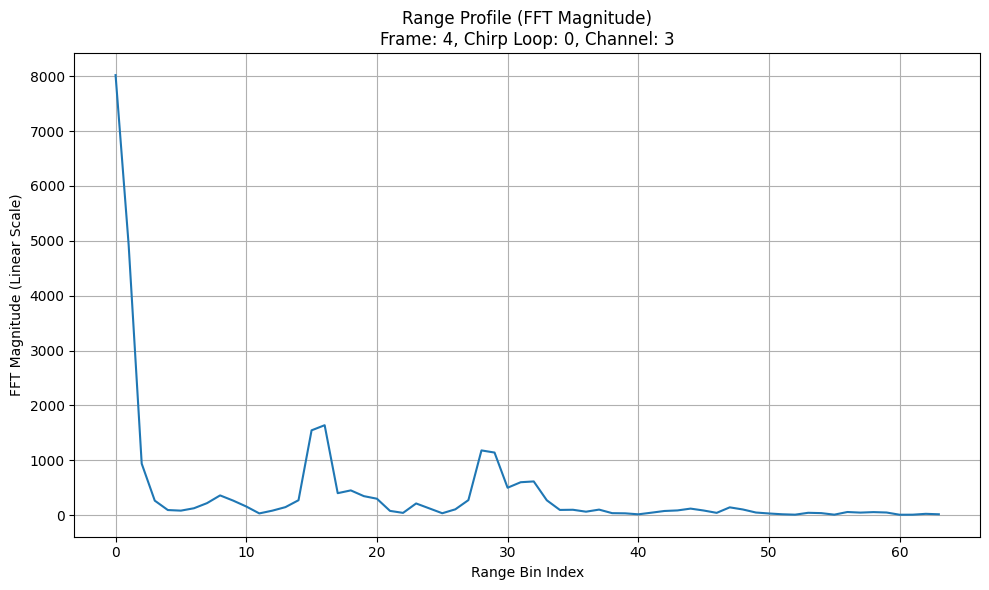

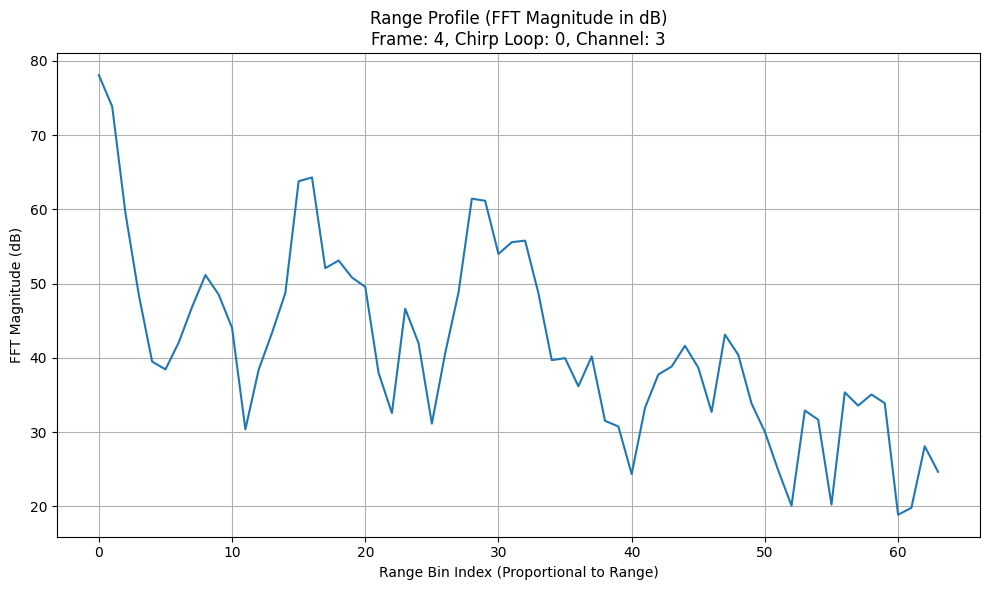

In [7]:
# --- Configuration: Select which chirp/channel to plot ---
frame_index_to_plot = 4       # Index of the frame to use
chirp_loop_index_to_plot = 0  # Index of the chirp loop within the frame
channel_index_to_plot = 3     # Index of the virtual channel (0 to num_tx_ant * num_rx_ant - 1)
# --- End Configuration ---

try:
    num_virtual_antennas = num_tx_ant * num_rx_ant

    num_frames_loaded = adc_data_frames.shape[0]
    num_chirp_loops_loaded = adc_data_frames.shape[1]
    num_channels_loaded = adc_data_frames.shape[2]
    num_samples_loaded = adc_data_frames.shape[3]
    print(f"Info: num_frames_loaded: {num_frames_loaded}, num_chirp_loops_loaded: {num_chirp_loops_loaded}, num_channels_loaded: {num_channels_loaded}, num_samples_loaded: {num_samples_loaded}")

    print(f"Selected data: Frame {frame_index_to_plot}, Chirp Loop {chirp_loop_index_to_plot}, Channel {channel_index_to_plot}")

    # Extract the chirp of interest from the frame
    selected_chirp = adc_data_frames[frame_index_to_plot, chirp_loop_index_to_plot, channel_index_to_plot, :]
    print(f"  Extracted chirp data shape: {selected_chirp.shape}")

    # Apply a Hanning window to reduce FFT sidelobes
    window = np.hanning(num_adc_samples)
    chirp_windowed = selected_chirp * window

    # FFT along the ADC samples dimension
    range_fft_complex = np.fft.fft(chirp_windowed, n=num_adc_samples)

    # Calculate Magnitude (often plotted in dB, but linear magnitude first)
    # We only need the first half of the FFT result due to symmetry for real inputs
    range_fft_magnitude = np.abs(range_fft_complex[:num_adc_samples // 2])

    # Plotting
    # Create an array representing FFT bins (proportional to range)
    range_bins = np.arange(num_adc_samples // 2)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(range_bins, range_fft_magnitude)

    ax.set_title(f'Range Profile (FFT Magnitude)\nFrame: {frame_index_to_plot}, Chirp Loop: {chirp_loop_index_to_plot}, Channel: {channel_index_to_plot}')
    ax.set_xlabel('Range Bin Index')
    ax.set_ylabel('FFT Magnitude (Linear Scale)')
    ax.grid(True)
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

    # Plot in dB
    # Avoid log(0) errors by adding a small epsilon or clipping
    epsilon = 1e-10
    range_fft_db = 20 * np.log10(range_fft_magnitude + epsilon)

    fig_db, ax_db = plt.subplots(figsize=(10, 6))
    ax_db.plot(range_bins, range_fft_db)

    ax_db.set_title(f'Range Profile (FFT Magnitude in dB)\nFrame: {frame_index_to_plot}, Chirp Loop: {chirp_loop_index_to_plot}, Channel: {channel_index_to_plot}')
    ax_db.set_xlabel('Range Bin Index (Proportional to Range)')
    ax_db.set_ylabel('FFT Magnitude (dB)')
    ax_db.grid(True)
    plt.tight_layout()
    plt.show()

except IndexError as ie:
    print(f"Error accessing data with selected indices: {ie}")
    print(f"  Check if data shape {adc_data_frames.shape} is compatible with indices.")
except Exception as e:
    print(f"An unexpected error occurred during range profile calculation/plotting: {e}")

#### Interactive Range Profile Player

In [8]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout, VBox, HBox, Output
from IPython.display import display, clear_output


# Get Data Dimensions
num_frames_loaded = adc_data_frames.shape[0]
num_chirp_loops_loaded = adc_data_frames.shape[1]
num_channels_loaded = adc_data_frames.shape[2] # num_tx_ant * num_rx_ant
num_samples_loaded = adc_data_frames.shape[3]

if num_samples_loaded != num_adc_samples:
        print(f"Warning: Shape mismatch! Expected {num_adc_samples} samples based on config, but found {num_samples_loaded} in data.")

if num_frames_loaded == 0 or num_chirp_loops_loaded == 0 or num_channels_loaded == 0:
    print("Error: Loaded data has zero dimensions in frames, chirp loops, or channels. Cannot create player.")
else:
    print(f"Data dimensions: Frames={num_frames_loaded}, Chirp Loops={num_chirp_loops_loaded}, Channels={num_channels_loaded}, Samples={num_samples_loaded}")

    # This is where the matplotlib plot will be displayed
    plot_output = Output()

    # This function will be called whenever a widget value changes
    def plot_range_profile(frame, chirp_loop, channel, plot_db):
        """Calculates and plots the range profile in the plot_output widget."""
        with plot_output: # Direct output to the Output widget
            clear_output(wait=True) # Clear previous plot before drawing new one

            try:
                # Extract the specific chirp data
                selected_chirp = adc_data_frames[frame, chirp_loop, channel, :]

                # Apply Windowing
                window = np.hanning(num_adc_samples)
                chirp_windowed = selected_chirp * window

                # Perform Range FFT
                range_fft_complex = np.fft.fft(chirp_windowed, n=num_adc_samples)
                range_fft_magnitude = np.abs(range_fft_complex[:num_adc_samples // 2])

                # Plotting
                range_bins = np.arange(num_adc_samples // 2)
                fig, ax = plt.subplots(figsize=(9, 5))
                if plot_db:
                    # Plot in dB
                    epsilon = 1e-10
                    range_fft_db = 20 * np.log10(range_fft_magnitude + epsilon)
                    ax.plot(range_bins, range_fft_db)
                    ax.set_ylim(bottom=0, top=80)
                    ax.set_ylabel('FFT Magnitude (dB)')
                    plot_title = f'Range Profile (dB)\nFrame: {frame}, Chirp Loop: {chirp_loop}, Channel: {channel}'
                else:
                    # Plot linear magnitude
                    ax.plot(range_bins, range_fft_magnitude)
                    ax.set_ylim(bottom=0, top=5000)
                    ax.set_ylabel('FFT Magnitude (Linear)')
                    plot_title = f'Range Profile (Linear)\nFrame: {frame}, Chirp Loop: {chirp_loop}, Channel: {channel}'


                ax.set_title(plot_title)
                ax.set_xlabel('Range Bin Index')
                ax.grid(True)
                plt.tight_layout()
                plt.show()

            except IndexError:
                    print(f"Error: Index out of bounds. Frame={frame}, Chirp={chirp_loop}, Channel={channel}")
            except Exception as e:
                    print(f"An error occurred during plotting: {e}")


    # --- Create Widgets ---
    # Sliders for navigation
    frame_slider = widgets.IntSlider(min=0, max=num_frames_loaded - 1, step=1, value=0, description='Frame:', continuous_update=False, layout=Layout(width='auto'))
    chirp_loop_slider = widgets.IntSlider(min=0, max=num_chirp_loops_loaded - 1, step=1, value=0, description='Chirp Loop:', continuous_update=False, layout=Layout(width='auto'))
    channel_slider = widgets.IntSlider(min=0, max=num_channels_loaded - 1, step=1, value=0, description='Channel:', continuous_update=False, layout=Layout(width='auto'))

    # Play widgets for animation (linked to sliders)
    frame_play = widgets.Play(min=0, max=num_frames_loaded - 1, step=1, interval=500, description="Play Frames") # interval in ms
    chirp_play = widgets.Play(min=0, max=num_chirp_loops_loaded - 1, step=1, interval=100, description="Play Chirps") # Faster chirp playback

    # Link Play widgets to sliders
    widgets.jslink((frame_play, 'value'), (frame_slider, 'value'))
    widgets.jslink((chirp_play, 'value'), (chirp_loop_slider, 'value'))

    # Checkbox for dB scale
    db_checkbox = widgets.Checkbox(value=True, description='Plot in dB')


    # Use interactive_output to link widgets to the plot function
    # This automatically calls plot_range_profile when widget values change
    interactive_plot = widgets.interactive_output(plot_range_profile, {
        'frame': frame_slider,
        'chirp_loop': chirp_loop_slider,
        'channel': channel_slider,
        'plot_db': db_checkbox
    })

    # Controls layout
    frame_controls = HBox([frame_slider, frame_play])
    chirp_controls = HBox([chirp_loop_slider, chirp_play])
    channel_controls = HBox([channel_slider, db_checkbox]) # Put checkbox next to channel selector

    # Combine all controls and the plot output
    ui = VBox([
        frame_controls,
        chirp_controls,
        channel_controls,
        plot_output # The Output widget where the plot appears
    ])

    display(ui)

    plot_range_profile(frame_slider.value, chirp_loop_slider.value, channel_slider.value, db_checkbox.value)

Data dimensions: Frames=100, Chirp Loops=256, Channels=6, Samples=128


### Micro Doppler Plot

In [ ]:
# TODO